In [2]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# Define the URL where your data is located
url = "https://www.eco-visio.net/api/aladdin/1.0.0/pbl/publicwebpageplus/data/100126474?idOrganisme=4586&idPdc=100126474&interval=4&flowIds=100126474"

# Make a GET request to the URL and read the response content
response = requests.get(url)
data_text = response.text

# Data Processing
# Remove first 2 and last 2 square brackets [[ ... ]]
txt = data_text[2:-2]
# Remove all quotation marks and backslashes
txt = txt.replace('\\"', '').replace('\\', '')
# Split rows by comma and square brackets
rows = txt.split("],[")

# Save in dataframe
data = {"date": [], "bike_count": []}
for row in rows:
    values = row.split(",")
    data["date"].append(values[0])
    data["bike_count"].append(values[1])

raw_df = pd.DataFrame(data)
raw_df.head()


,date,bike_count
0,"""04/25/2012""","""4593"""
1,"""04/26/2012""","""5849"""
2,"""04/27/2012""","""5846"""
3,"""04/28/2012""","""4261"""
4,"""04/29/2012""","""1901"""


In [4]:
bike_df = raw_df.copy()

# remove " signs before and after entries in both cols
bike_df["date"] = bike_df["date"].str.replace('"', "")
bike_df["bike_count"] = bike_df["bike_count"].str.replace('"', "")

# convert date col to datetime
bike_df["date"] = pd.to_datetime(bike_df["date"])
# convert bike_count col to int
bike_df["bike_count"] = bike_df["bike_count"].astype(int)

bike_df.index = bike_df["date"]
bike_df.drop("date", axis=1, inplace=True)
bike_df

,bike_count
date,
2012-04-25,4593
2012-04-26,5849
2012-04-27,5846
2012-04-28,4261
2012-04-29,1901
...,...
2024-01-21,994
2024-01-22,3398
2024-01-23,4427


In [5]:
# find missing days in the data
# create a list of all days in the range
all_days = pd.date_range(start=bike_df.index.min(), end=bike_df.index.max(), freq="D")
# find the missing days
missing_days = all_days.difference(bike_df.index)
print(missing_days)

DatetimeIndex(['2022-01-05', '2022-01-10', '2022-01-17', '2022-02-25',
               '2022-02-26', '2022-02-27', '2022-03-01', '2022-03-03',
               '2023-01-31', '2023-03-04', '2023-03-07'],
              dtype='datetime64[ns]', freq=None)


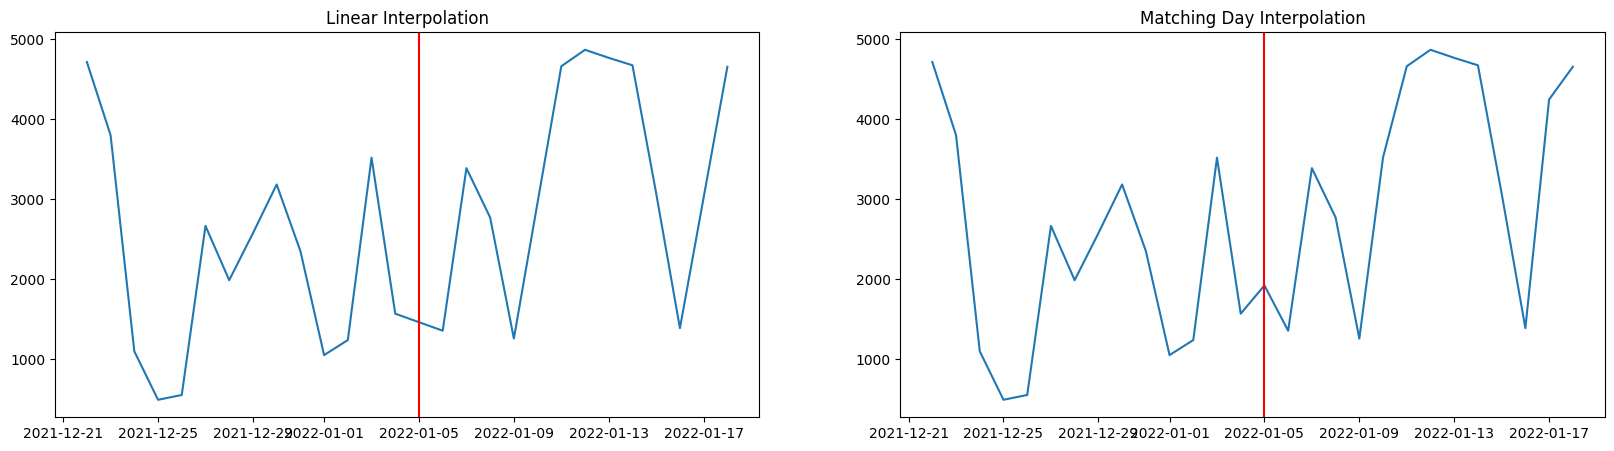

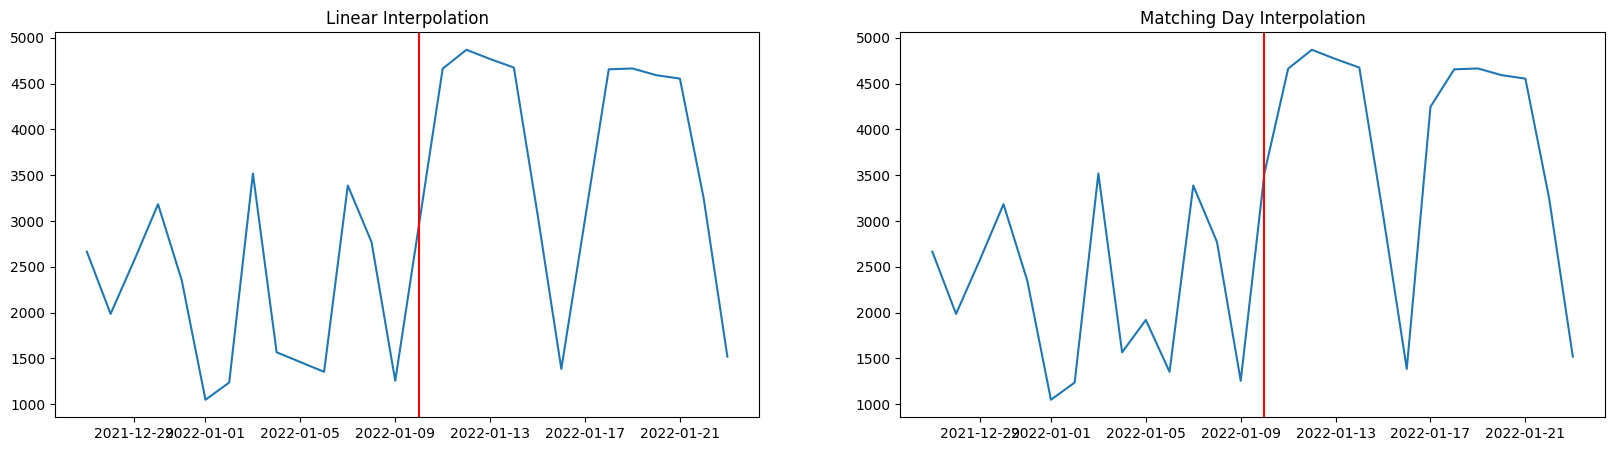

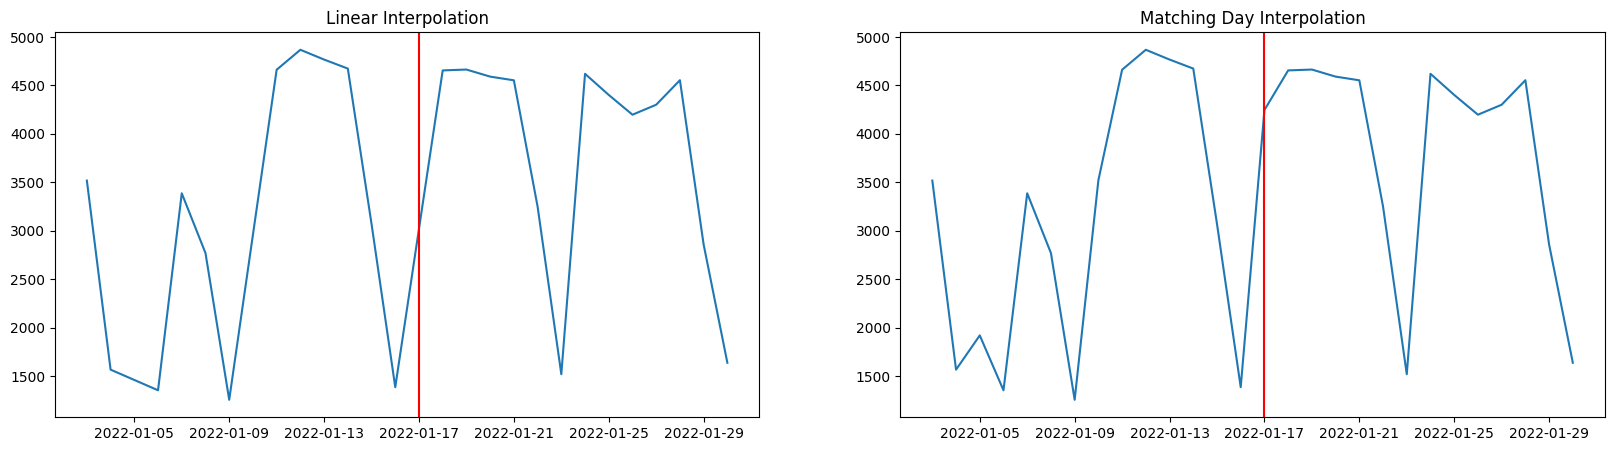

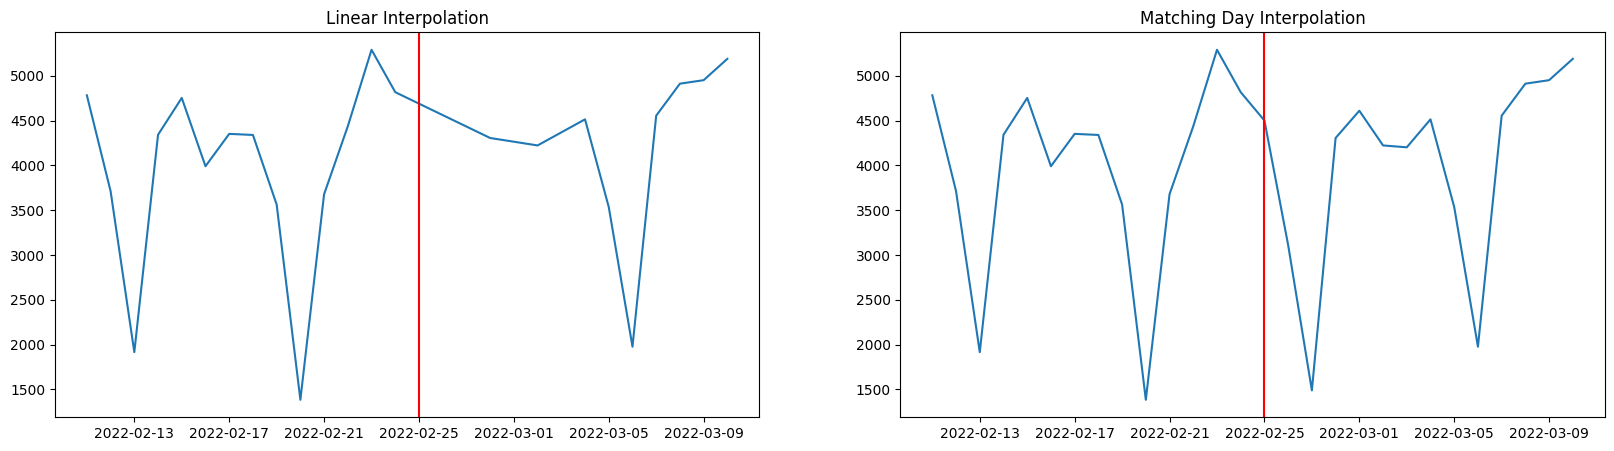

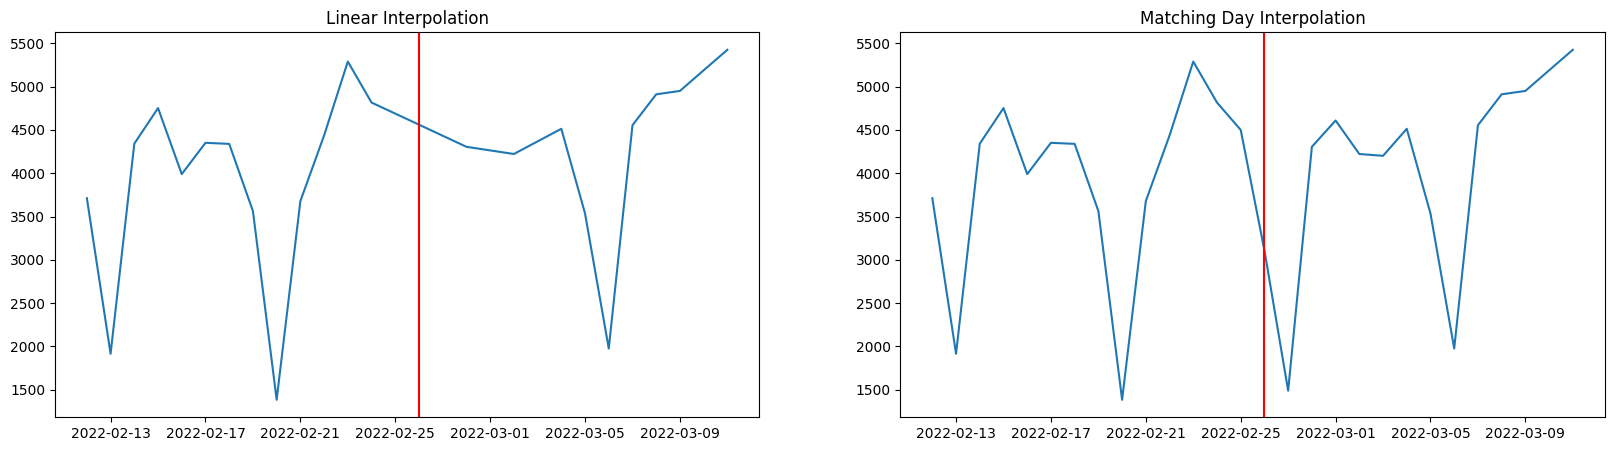

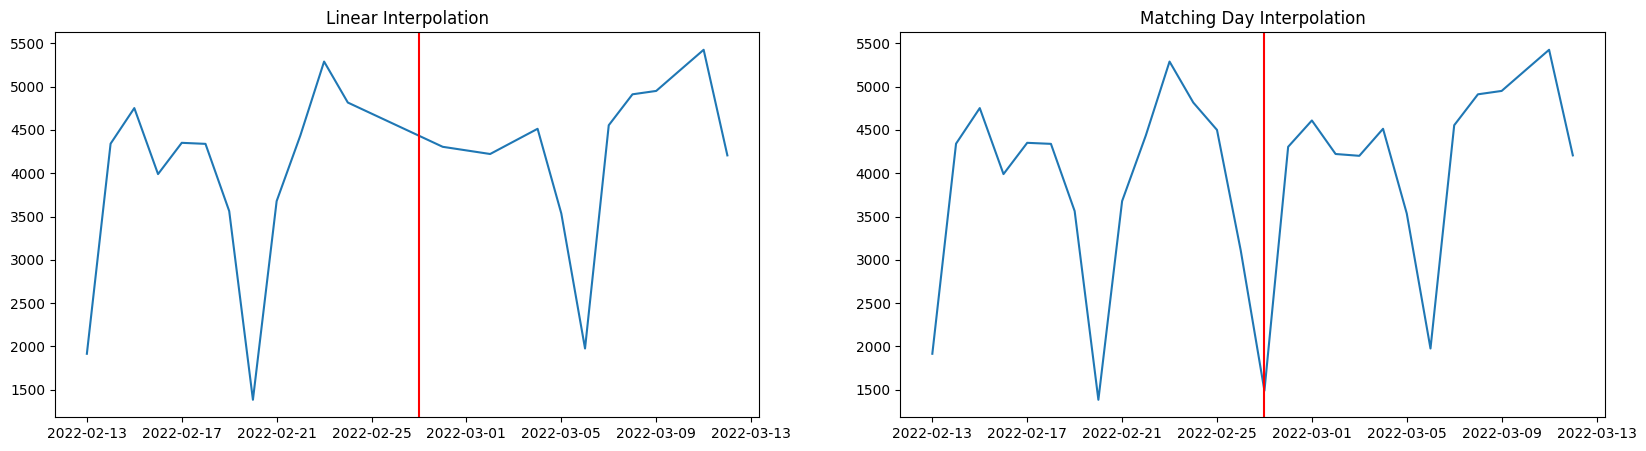

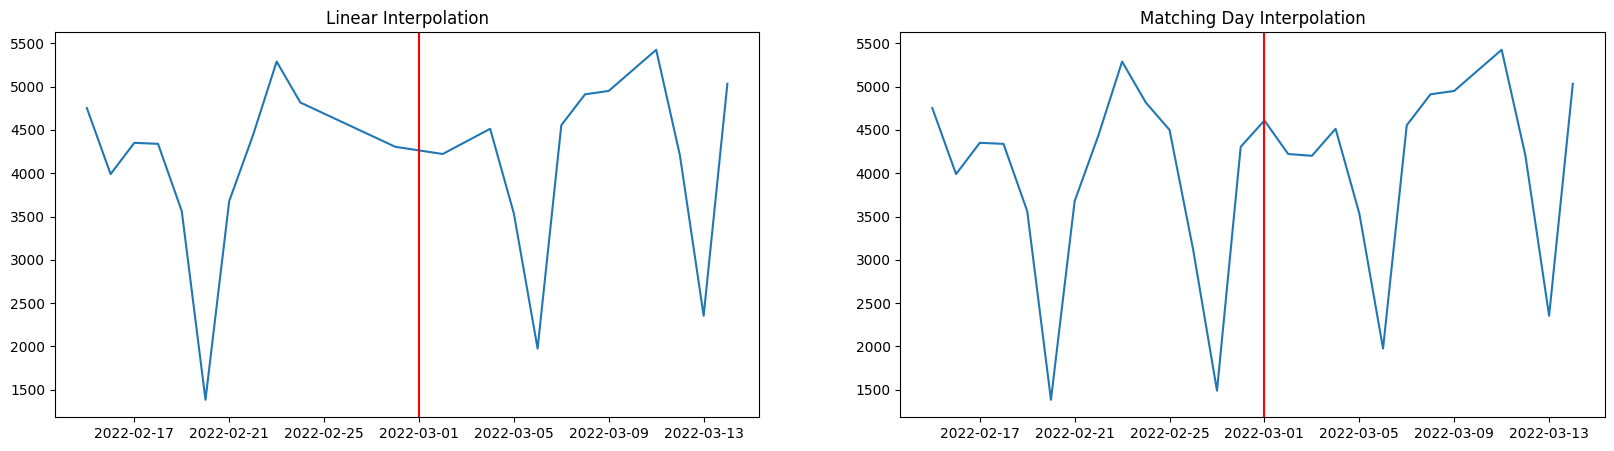

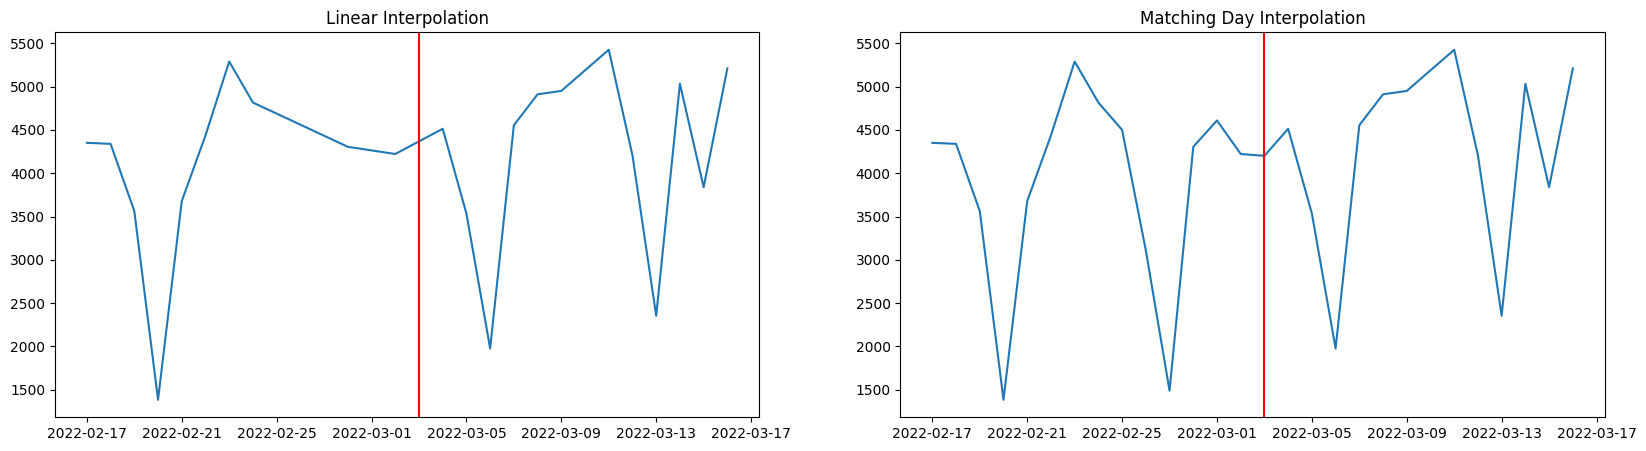

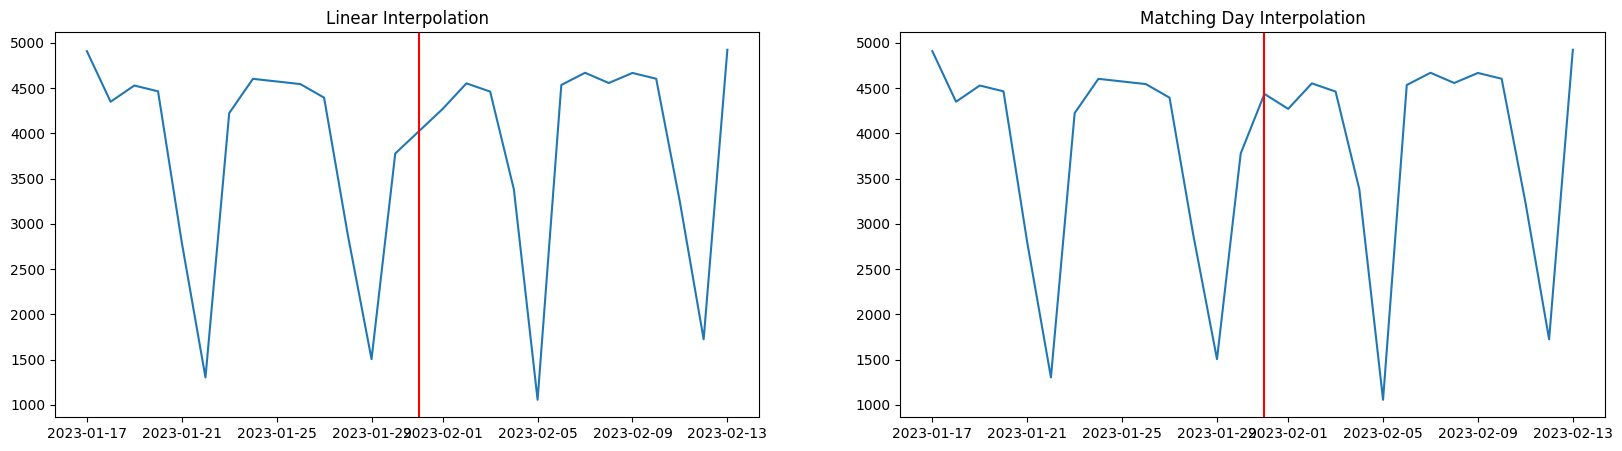

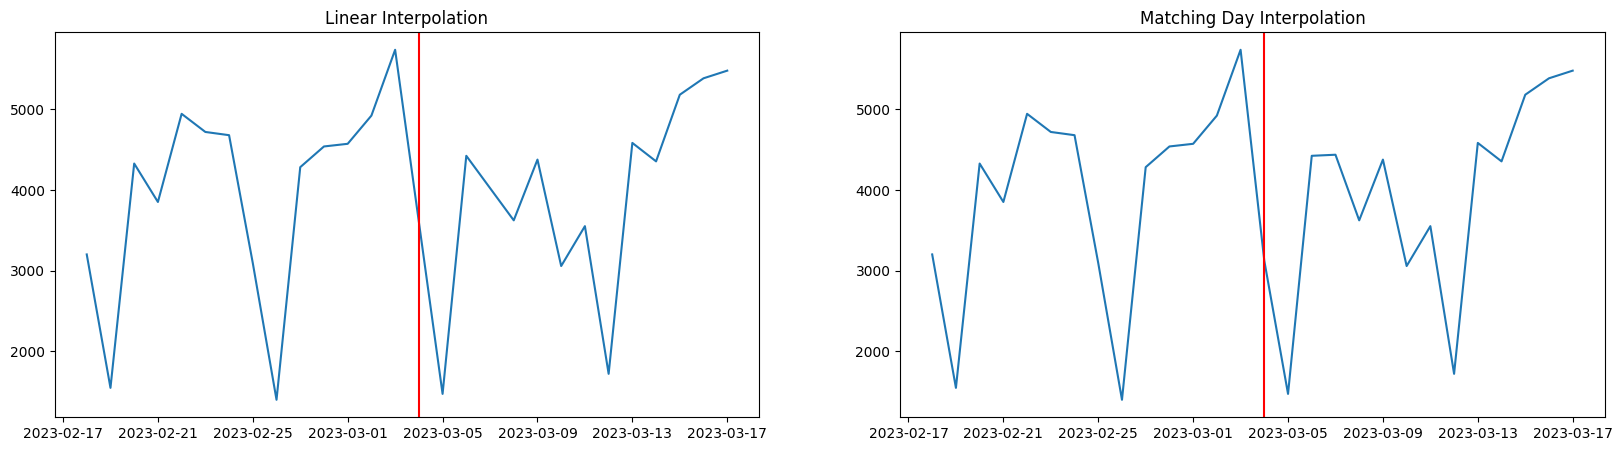

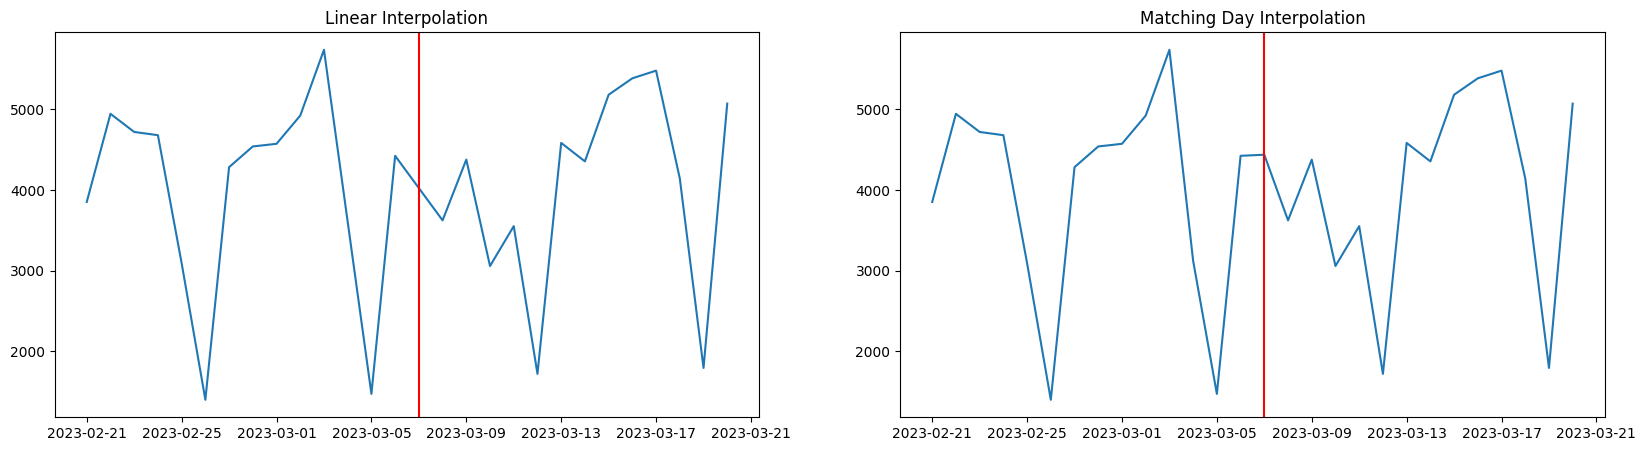

In [6]:
bike_df_interp = bike_df.copy()
# reindex daily
bike_df_interp = bike_df_interp.resample('D').mean()

# do linear interpolation
bike_df_interp_lin = bike_df_interp.interpolate(method="linear")

# for missing days
    # match days in dataframe with same weekday and same weeknum
    # and take the avg as an estimate for the missing day

for day in missing_days:

    # find the weekday and weeknum of the missing day
    weekday = day.weekday()
    weeknum = day.week

    # find all the days in the dataframe with the same weekday and weeknum
    mask = (bike_df.index.weekday == weekday) & (bike_df.index.isocalendar().week == weeknum) & (bike_df.index.month == day.month)
    similar_days_df = bike_df[mask]
    # display(similar_days_df)

    # find the average bike count for the same weekday and weeknum
    avg_bike_count = similar_days_df["bike_count"].mean()
    # print(avg_bike_count)
    
    # print(f"Missing day: {str(day.date())}")

    # add the missing day to the dataframe
    bike_df_interp.loc[day] = avg_bike_count

for day in missing_days:

    # get index of the missing day
    idx = bike_df_interp.index.get_loc(day)

    fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    ax1.plot(bike_df_interp_lin.iloc[idx-14:idx+14])
    ax2.plot(bike_df_interp.iloc[idx-14:idx+14])
    # highlight missing day
    ax1.axvline(x=day, color="red")
    ax2.axvline(x=day, color="red")
    # set title
    ax1.set_title("Linear Interpolation")
    ax2.set_title("Matching Day Interpolation")
    plt.show()


In [9]:
# save bike_df_interp to csv
# with name starting with earlies date and ending with latest date
date_min = bike_df_interp.index.min().date()
date_max = bike_df_interp.index.max().date()
filename = f"./data/{date_min}_{date_max}_KA_bike_count.csv"
bike_df_interp.to_csv(filename)

In [22]:
# merge bike_df_interp with weather daily with same name
fname_weather = f"./data/{date_min}_{date_max}_KA_weather_daily.csv" 
# read weather daily csv
weather_df = pd.read_csv(fname_weather)

# convert date col to datetime
weather_df["date"] = pd.to_datetime(weather_df["date"])
# set date col as index
weather_df.index = weather_df["date"]
# drop date col
weather_df.drop("date", axis=1, inplace=True)

# merge bike_df_interp with weather daily by date
bike_weather_df = pd.merge(bike_df_interp, weather_df, left_index=True, right_index=True)
# check for any missing values
bike_weather_df.isna().sum()
# interpolate missing values
bike_weather_df = bike_weather_df.interpolate(method="linear")

# save bike_weather_df to csv
# with name starting with earlies date and ending with latest date
date_min = bike_weather_df.index.min().date()
date_max = bike_weather_df.index.max().date()
filename = f"./data/{date_min}_{date_max}_KA_bike_weather.csv"
bike_weather_df.to_csv(filename)